## Car Tracking Task
We first evaluate the DEnKF in a position tracking task: a robot vehicle moving along a circular path. The robot state is given as ${\bf x} =[x, y, \cos{\phi}, \sin{\phi}]^T$, the dynamic model is
\begin{aligned}
\left\{ \begin{array}{rcl}
\dot x =& v \cos{\phi}\\
\dot y =& v \sin{\phi}\\
\dot \phi =& \frac{v}{L} \tan{\delta}
\end{array}\right.
\end{aligned}

where $L$ is the distance between the front of the vehicle and its center of gravity, $\delta$ is the steering angle, and $v$ is the velocity.
The observation is replaced by a top view image at each timestep. The raw observation ${\bf y}$ is an image with $224 \times 224 \times 3$ pixels given at each timestep. We define the learned observation $\tilde{{\bf y}}$ has the dimension of two, where $\tilde{{\bf y}} = [x,y]^T$ representing the position of the robot vhicle.

### 1. data preparation
We collect 120 sequences both in high-dimension and in low-dimension of the robot vehicle dynamics using the CARLO simulator. We enable a steering angle $\delta$ to randomly change at every timestep, where $\delta \in [-0.1, 0.2]$, a constant velocity $v$, where $v = 3m/s$, and $L=1$. We use 100 recorded sequences with each sequence containing 535 steps for training, and the rest 20 sequences for testing.
You can downloaded the dataset from `https://huggingface.co/datasets/liuxiao1468/simulation_car_dataset`.

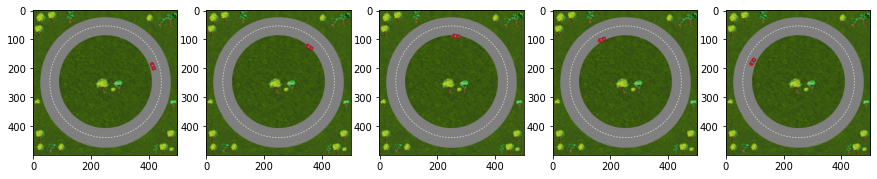

In [1]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np

fig = plt.figure(figsize=(15, 10))
for i in range (5):
    plt.subplot(1, 5, i+1)
    image = Image.open('./dataset/car_dataset/sim_01/car-'+str((i+1)*50).zfill(4)+'.jpg')
    plt.imshow(image)
plt.show()

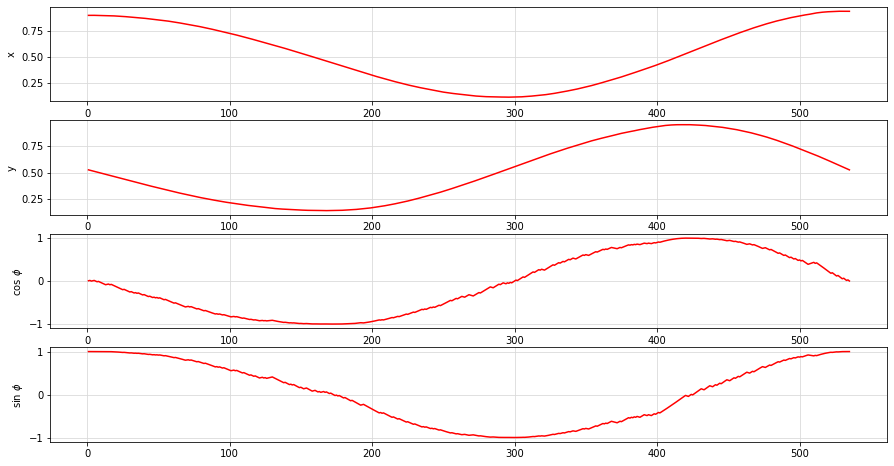

In [2]:
import pickle

# visualize data for sim_01

dataset = pickle.load(open("./dataset/car_dataset_train.pkl", "rb"))
gt = []
for i in range (535):
    gt.append(dataset[i][2])
gt = np.array(gt)
x = np.linspace(1, gt.shape[0], gt.shape[0])
legend_y = ['x', 'y', 'cos $\phi$', 'sin $\phi$']
fig = plt.figure(figsize=(15, 8))
for i in range (gt.shape[1]):
    plt.subplot(gt.shape[1], 1, i+1)
    plt.plot(
        x,
        gt[:, i].flatten(),
        color="r",
        linewidth=1.5,
        label="GT",
    )
    plt.ylabel(legend_y[i])
    plt.grid(color="0.85")
plt.show()

### 2. dataloader
Now all the data is collected and ready to use, we can write the dataloader class as bellow. Note that dataloader is the generator used for feeding the data to the model, here we implement the dataloader with "pre-defined" parameter only suitable for this car positional tracking task. 
The same implementation can also be found in `PyTorch/dataset/dataloader.py`.

In [4]:
import os
import random
from PIL import Image
import cv2
import numpy as np
from torch.utils.data import Dataset
import pickle
import torch
from einops import rearrange, repeat
from torch.distributions.multivariate_normal import MultivariateNormal
import math

import warnings
warnings.filterwarnings('ignore')

class utils:
    def __init__(self, num_ensemble, dim_x, dim_z):
        self.num_ensemble = num_ensemble
        self.dim_x = dim_x
        self.dim_z = dim_z

    def multivariate_normal_sampler(self, mean, cov, k):
        sampler = MultivariateNormal(mean, cov)
        return sampler.sample((k,))

    def format_state(self, state):
        state = repeat(state, "k dim -> n k dim", n=self.num_ensemble)
        state = rearrange(state, "n k dim -> (n k) dim")
        cov = torch.eye(self.dim_x) * 0.05
        init_dist = self.multivariate_normal_sampler(
            torch.zeros(self.dim_x), cov, self.num_ensemble
        )
        state = state + init_dist
        state = state.to(dtype=torch.float32)
        return state


class CarDataset(Dataset):
    # Basic Instantiation
    def __init__(self, mode):
        self.mode = mode
        if self.mode == "train":
            self.dataset_path = './dataset/car_dataset_train.pkl'
            self.num_ensemble = 32
        elif self.mode == "test":
            self.dataset_path = './dataset/car_dataset_test.pkl'
            self.num_ensemble = 32
        self.dataset = pickle.load(open(self.dataset_path, "rb"))
        self.dataset_length = len(self.dataset)
        self.dim_x = 4
        self.dim_z = 4
        self.utils_ = utils(
            self.num_ensemble, self.dim_x, self.dim_z
        )

    def process_image(self, img_path):
        img_array = cv2.imread(img_path)
        img_array = cv2.resize(img_array, (224, 224))
        img_array = img_array / 255.0
        return img_array

    # Length of the Dataset
    def __len__(self):
        return self.dataset_length - 2

    # Fetch an item from the Dataset
    def __getitem__(self, idx):
        # make sure always take the data from the same sequence
        not_valid = True
        while not_valid:
            try:
                if self.dataset[idx][0] == self.dataset[idx + 1][0]:
                    not_valid = False
                else:
                    idx = random.randint(0, self.dataset_length)
            except:
                idx = random.randint(0, self.dataset_length)

        # the observation to the model
        pre = self.dataset[idx][2]
        gt = self.dataset[idx + 1][2]
        pre = torch.tensor(pre, dtype=torch.float32)
        pre = rearrange(pre, "(k dim) -> k dim", k=1)
        ensemble_pre = self.utils_.format_state(pre)

        gt = torch.tensor(gt, dtype=torch.float32)
        gt = rearrange(gt, "(k dim) -> k dim", k=1)

        # gt image
        img_path = (
            "./dataset"
            + self.dataset[idx + 1][3]
        )
        gt_image = self.process_image(img_path)
        gt_image = torch.tensor(gt_image, dtype=torch.float32)
        gt_image = rearrange(gt_image, "h w ch -> ch h w")

        data = (pre, ensemble_pre, gt, gt_image)

        return data